

#Firstly let's import the data and divide it into subtrajectories right from the start. So each subtrajectory will have START amount of SnC, END amount of SnC, AGE at the start point (here in days), and DURATION of subtrajectory (in days). So every subtrajectory has a format of (START,END,AGE,DURATION). Subtrajectories are distributed among mice so to use it for bootstraping


In [ ]:
import pandas as pd
table = pd.read_csv('Table_mice.csv')
import matplotlib.pyplot as plt
import numpy as np
rows = table.values.tolist()
columns = table.columns.tolist()

master_array = [[] for _ in range(33)] # 33 here is the number of samples (mice)
for j,row in enumerate(rows):
    count = 7*8
    null_count = 0 # some rows contain NaNs, so we have to handle it
    temp = 0 # serves as the END point
    row = row[1:]
    for i in range(len(row)-1):
        if np.isnan(row[i+1]):
            if null_count==0:
                temp = row[i] #if no nulls after START -> next value is END
            else:
                pass
            null_count+=1 # NaNs count
            continue
        else:
            if null_count==0:
                master_array[j].append((row[i], row[i+1], count, 7*8)) #start value, end_value, start_time, delta_t
                count += 7*8
            else:
                master_array[j].append((temp, row[i+1], count, 7*8*(null_count+1))) #start value, end_value, start_time, delta_t
                count += 7*8*(null_count+1)
                null_count = 0

# Now we can to implement Ito process since authors used special library specific to different language, so we will implement Ito process integration from scratch (with reflections as described in the article)

# Optimization with Cython is crusial, since Cython optimized code will solve single ODE in 50 microseconds instead of 2.5ms (which will make our code 50 times faster)

In [ ]:
%load_ext Cython

In [ ]:
%%cython

import numpy as np
cimport numpy as np

def Integrator_3_cython(double X0, double t0, double dt, int steps, double[:] parameters):
    cdef double[:] solution = np.empty(steps + 1, dtype=np.double) # predefine solution array
    solution[0] = X0 # initial conditions

    cdef double beta, eta, kappa, epsilon
    beta, eta, kappa, epsilon = parameters[0], parameters[1], parameters[2], parameters[3]

    cdef double[:] t_range = np.linspace(t0, t0 + dt * steps, steps + 1) # grid for time
    cdef double[:] normal_samples = np.random.normal(0, 1, steps) #Random walk simulation

    cdef int i
    cdef double X, step

    for i in range(1, steps + 1):
        X = solution[i - 1]
        step = eta * t_range[i] - beta * X / (kappa + X) + (2 * epsilon) ** 0.5 * normal_samples[i - 1] #step of integration (dt=1, so ommited)
        solution[i] = abs(X + step) #Reflection if shochastic term makes solution negative

    return np.asarray(solution)

Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_04d96fa80e48e4b0108a9bc6d0d71e2777e7fc74.c:1215:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [ ]:
%%cython

UsageError: %%cython is a cell magic, but the cell body is empty.


# For finding optimal parameters we will perform grid search

In [ ]:
sample_array = [item for sublist in master_array for item in sublist] # make a single list with no differentiation between samples

In [ ]:
def get_likelihood(parameters): #get likelihood of observing a single sub-trajectory
  beta, eta, kappa, epsilon = parameters
  L = 0
  bootstrap_depth = 100 # here we use smaller number of bootstrap steps since we each boostrap is equivalent of ~10 GFLOPS
  for arr in sample_array:
    initial_value, end_value, start_time, duration = arr
    temp = np.empty(bootstrap_depth)
    for i in range(bootstrap_depth):
        result = Integrator_3_cython(initial_value, start_time, 1, duration, np.array((beta, eta, kappa, epsilon), dtype=np.double))
        temp[i] = result[-1] # end amount of SnC
    p = np.mean(temp >= end_value) #find in how many simulations end value of SnC was achieved
    L += np.log(p)
  return L

# Here we will introduce grid, for each of 4 parameters there are 12 log uniformly distributed values (from $e^{-12}$ to $e^1$), $12^4$ grid points in total ~20k

In [ ]:
from itertools import product

In [ ]:
start_exponent = -10
end_exponent = 1
num_points = 12


exponents = np.linspace(start_exponent, end_exponent, num_points)
values = np.exp(exponents)

betas, etas, kappas, epsilons = values,values,values,values




In [ ]:
param_grid = np.array(np.meshgrid(betas, etas, kappas, epsilons)).T.reshape(-1, 4)

results_array = np.zeros((len(betas), len(etas), len(kappas), len(epsilons)))

# Here we are perfoming evaluation of log likelihood of observing this set of parameters for every point in the grid with 100 bootstraps

In [ ]:
for i, params in enumerate(param_grid):

    results_array.flat[i] = get_likelihood(params)

<ipython-input-13-0a6e0efede0f>:12: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)


In [ ]:
np.save('results.npy',results_array)

In [ ]:
test_array = results_array
test_array[test_array == 0] = -10**9
max_index = np.unravel_index(test_array.argmax(), test_array.shape)

print("Position of maximum value:", max_index) # here we receive the optimal set of parameters

Position of maximum value: (8, 1, 10, 6)


In [ ]:
dic = {'beta':values, 'eta':values, 'kappa':values, 'epsilons':values }

In [ ]:
c = 0
params = []
for key, value in dic.items():
  print(key,value[max_index[c]])
  params.append(max_index[c])
  c+=1


beta 0.1353352832366127
eta 0.00012340980408667956
kappa 1.0
epsilons 0.01831563888873418


In [ ]:
!pip install lifelines

# Here we will simulate survival curve of mice under restritcion on SnC amount

In [ ]:
indiv_num = 4000
arr = []
for i in range(indiv_num):
  results = Integrator_3_cython(1,1,1,150*7,np.array(np.double(params)))
  arr.append(results)
arr = np.array(arr)
dt = np.argmax(arr > 2.5,axis=1)
dt

df = pd.DataFrame(dt,columns=['time'])
df['event']=1
df.loc[df['time'] == 0,'event']=0
df.loc[df['time']==0,'time']=50

In [ ]:
from lifelines import WeibullFitter

<Axes: >

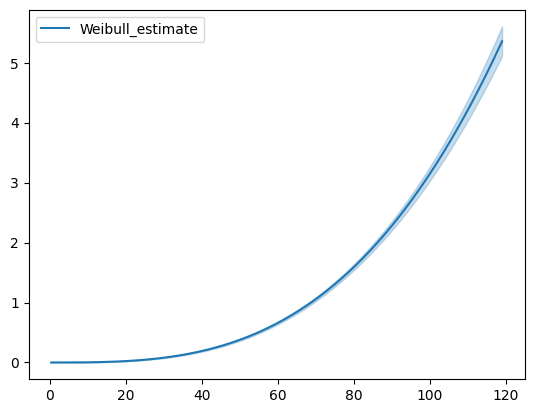

In [ ]:
wb = WeibullFitter()
data = [df]

wb.fit(data[0]['time']/7, data[0]['event'])
wb.plot()

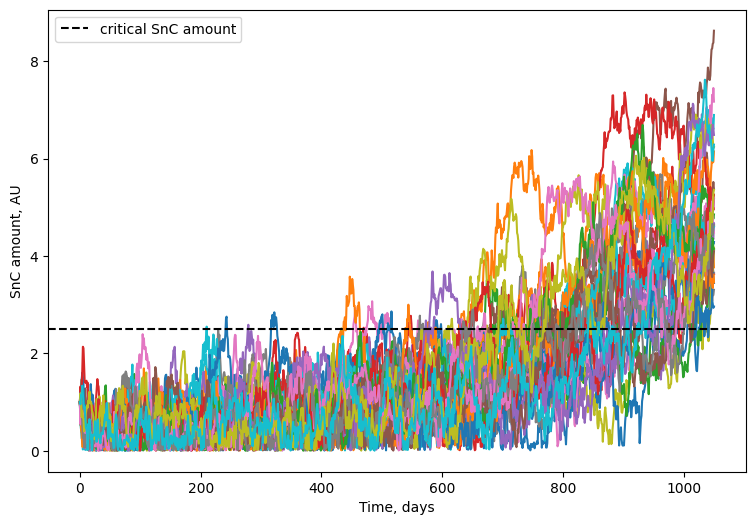

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
for res in arr[:30]:
  ax.plot(res)
ax.set_xlabel('Time, days')
ax.set_ylabel('SnC amount, AU')
ax.axhline(y=2.5, color='black', linestyle='--', label = 'critical SnC amount')
ax.legend()

In [ ]:
from lifelines import KaplanMeierFitter

<Axes: xlabel='Time (weeks)', ylabel='Survival ratio'>

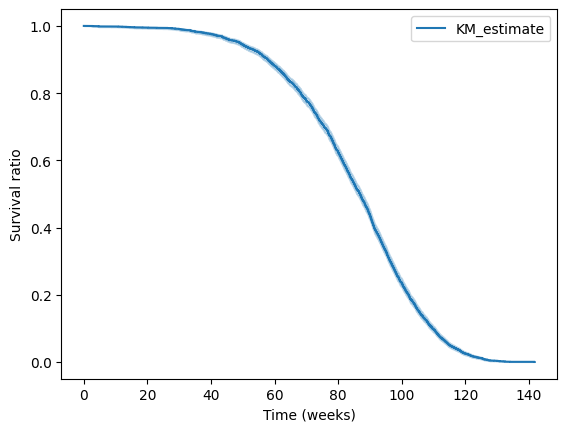

In [ ]:
km = KaplanMeierFitter(alpha=0.05)

data = [df]

km.fit(data[0]['time']/7, data[0]['event'])
km.plot(xlabel='Time (weeks)', ylabel ='Survival ratio')

##Prepare SR model and load packages

In [ ]:
!pip install cython

In [ ]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=56a68e2f15f382c3ace5b1f18fb04fc13b52580802dd963f73d42a04992a2e7e
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
%load_ext Cython

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%%cython
import numpy as np

def Integrator_3_cython(double X0, double t0, double dt, int steps, double[:] parameters):
    cdef double[:] solution = np.empty(steps + 1, dtype=np.double)
    solution[0] = X0

    cdef double beta, eta, kappa, epsilon
    beta, eta, kappa, epsilon = parameters[0], parameters[1], parameters[2], parameters[3]

    cdef double[:] t_range = np.linspace(t0, t0 + dt * steps, steps + 1)
    cdef double[:] normal_samples = np.random.normal(0, 1, steps)

    cdef int i
    cdef double X, step

    for i in range(1, steps + 1):
        X = solution[i - 1]
        step = eta * t_range[i] - beta * X / (kappa + X) + (2 * epsilon) ** 0.5 * normal_samples[i - 1]
        solution[i] = abs(X + step)

    return np.asarray(solution)

#Survival curves

##For Drosophila

###fully fed

In [ ]:
beta = 1 #h^-1
kappa = 1 #[au]
epsilon = 1 #[au]^2h^-1
eta = 0.03/24 #[au]h^-1day^-1
params_model = np.array([beta,eta,kappa,epsilon])
indiv_num = 4000

SR model simulates 4000 data

In [ ]:
arr_FF = []
for i in range(indiv_num):
  results = Integrator_3_cython(1,1,1,50*24,params_model)
  arr_FF.append(results)
arr_FF = np.array(arr_FF)

Use threshold Xc=15

In [ ]:
FF = np.argmax(arr_FF > 15,axis=1)
FF

array([551, 608, 616, ..., 620, 594, 657])

In [ ]:
df_FF = pd.DataFrame(FF,columns=['time'])
df_FF['event']=1
df_FF.loc[df_FF['time'] == 0,'event']=0
df_FF.loc[df_FF['time']==0,'time']=50

###lifespan-extending(LE) dietary

In [ ]:
beta = 1
kappa = 1
epsilon = 1
eta = 0.02/24
params_model = np.array([beta,eta,kappa,epsilon])
indiv_num = 4000

In [ ]:
arr_LE = []
for i in range(indiv_num):
  results = Integrator_3_cython(1,1,1,50*24,params_model)
  arr_LE.append(results)
arr_LE = np.array(arr_LE)

In [ ]:
LE = np.argmax(arr_LE > 15,axis=1)
LE

array([ 731, 1130,  993, ..., 1095, 1014,  845])

In [ ]:
df_LE = pd.DataFrame(LE,columns=['time'])
df_LE['event']=1
df_LE.loc[df_LE['time'] == 0,'event']=0
df_LE.loc[df_LE['time']==0,'time']=50

###plot harzad carve

In [ ]:
from lifelines import WeibullFitter

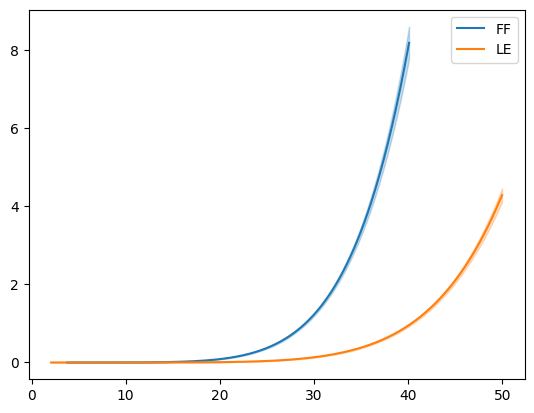

In [ ]:
wb = WeibullFitter()
label = ["FF",'LE']
data = [df_FF,df_LE]
for i in range(2):
  wb.fit(data[i]['time']/24, data[i]['event'],label=label[i])
  wb.plot()

## plot survival carve

In [ ]:
from lifelines import KaplanMeierFitter

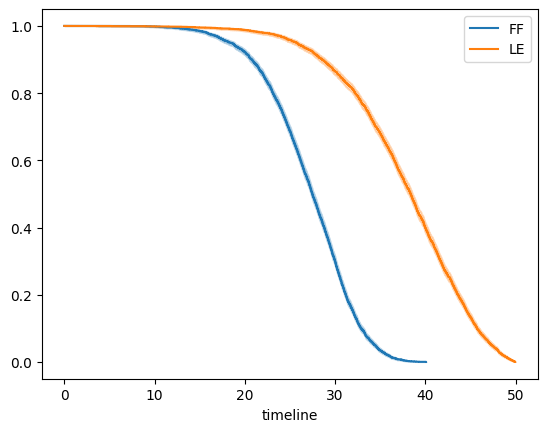

In [ ]:
km = KaplanMeierFitter(alpha=0.05)
label = ["FF",'LE']
data = [df_FF,df_LE]
for i in range(2):
  km.fit(data[i]['time']/24, data[i]['event'],label=label[i])
  km.plot()

##For C.elegans

In [ ]:
beta = 1
kappa = 1
epsilon = 1
eta = 0.07/24
params_model = np.array([beta,eta,kappa,epsilon])
indiv_num = 4000

In [ ]:
arr = []
for i in range(indiv_num):
  results = Integrator_3_cython(1,1,1,50*24,params_model)
  arr.append(results)
arr = np.array(arr)

In [ ]:
a = np.argmax(arr > 20,axis=1)
a

array([403, 297, 401, ..., 361, 310, 388])

In [ ]:
df = pd.DataFrame(a,columns=['time'])
df['event']=1
df.loc[df['time'] == 0,'event']=0
df.loc[df['time']==0,'time']=50

<Axes: >

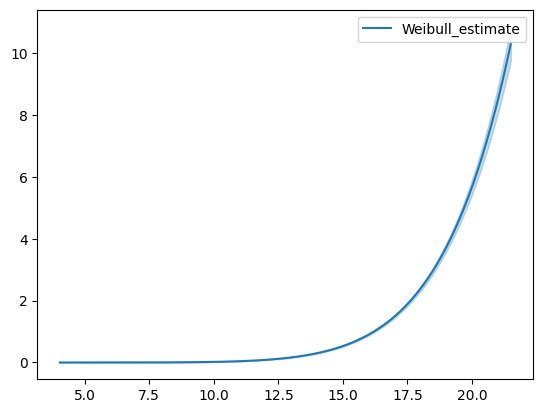

In [ ]:
wb = WeibullFitter()
wb.fit(df['time']/24, df['event'])
wb.plot()

<Axes: xlabel='timeline'>

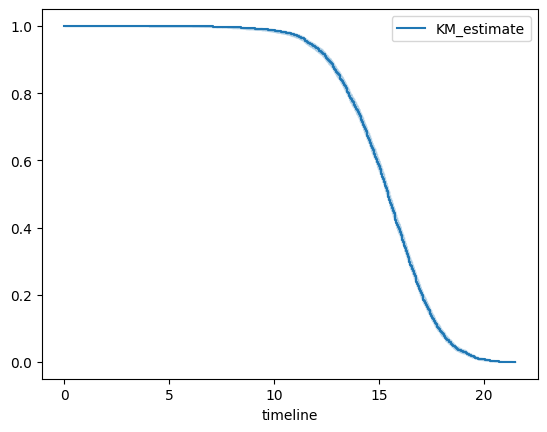

In [ ]:
km = KaplanMeierFitter(alpha=0.05)
km.fit(df['time']/24, df['event'])
km.plot()

#plot paper data

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
dbl=pd.read_csv("/content/Dros_Black.csv",header=None)
db=pd.read_csv("/content/Dros_Blue.csv",header=None)
dg=pd.read_csv("/content/Dros_Green.csv",header=None)
dr=pd.read_csv("/content/Dros_Red.csv",header=None)

In [ ]:
dbl["label"]="LE"
db["label"]="FF to LE day22"
dg["label"]="FF to LE day14"
dr["label"]="FF"

In [ ]:
all=pd.concat([dbl,db,dg,dr],axis=0)


In [ ]:
all

,0,1,label
0,1.356339,-5.796114,LE
1,2.114944,-5.578286,LE
2,3.173254,-6.283886,LE
3,4.212511,-5.732000,LE
4,4.461439,-5.661286,LE
...,...,...,...
29,2.042909,-6.824000,FF
30,11.712727,-5.032000,FF
31,19.499879,-2.984000,FF
32,23.669091,-2.152000,FF


In [ ]:
all.columns=["time","harzad","label"]

In [ ]:
colors = {'LE': 'black', 'FF': 'red', "FF to LE day14": "green", "FF to LE day22":"blue"}
palette = [colors[label] for label in all['label'].unique()]

<Axes: xlabel='time', ylabel='harzad'>

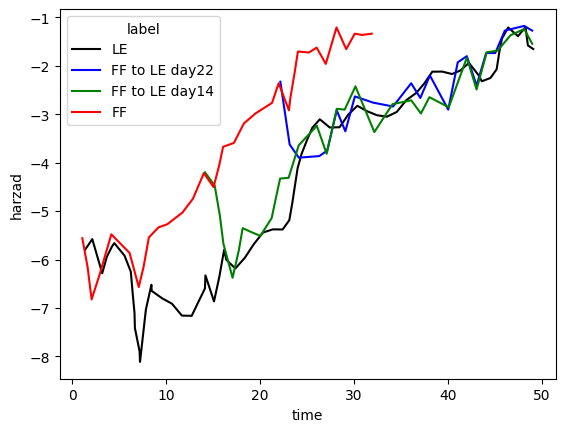

In [ ]:
sns.lineplot(all,x="time",y="harzad",hue="label",palette=palette)

In [ ]:
all.columns=["time","harzad","label"]
all["event"]=0

In [ ]:
all.loc[all["time"] >15,'event']=1

In [ ]:
all['time'].sort_values()
all

,time,harzad,label,event
0,1.356339,-5.796114,LE,0
1,2.114944,-5.578286,LE,0
2,3.173254,-6.283886,LE,0
3,4.212511,-5.732000,LE,0
4,4.461439,-5.661286,LE,0
...,...,...,...,...
29,2.042909,-6.824000,FF,0
30,11.712727,-5.032000,FF,0
31,19.499879,-2.984000,FF,1
32,23.669091,-2.152000,FF,1


In [ ]:
import matplotlib.pyplot as plt

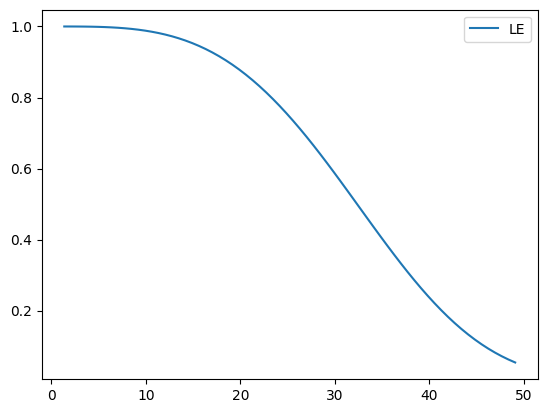

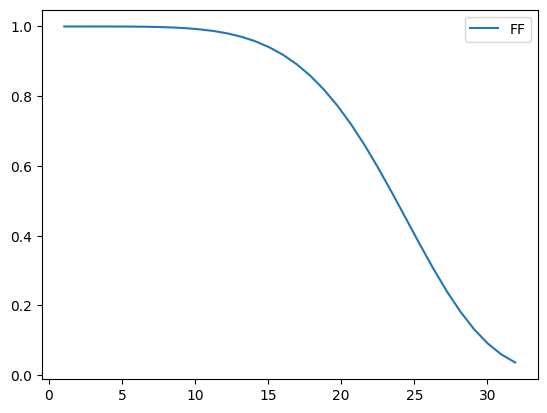

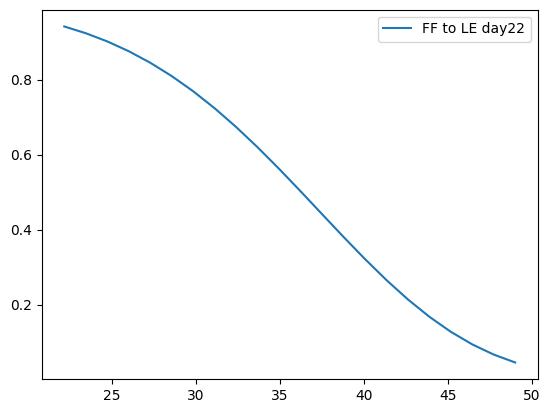

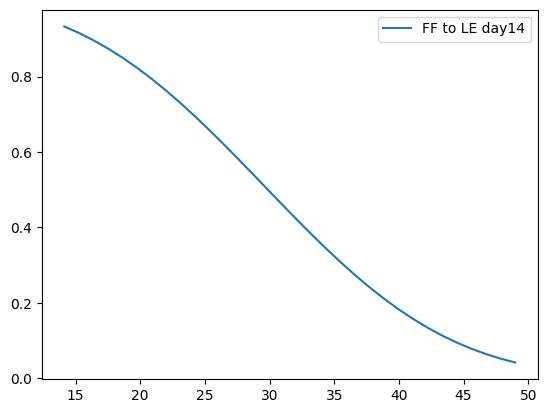

In [ ]:
wb = WeibullFitter()
for i in ["LE","FF","FF to LE day22","FF to LE day14"]:
  wb.fit(all.loc[all['label']==i]['time'], all.loc[all['label']==i]['event'],label=i)
  wb.survival_function_.plot()
  plt.show()

In [ ]:
from lifelines import KaplanMeierFitter

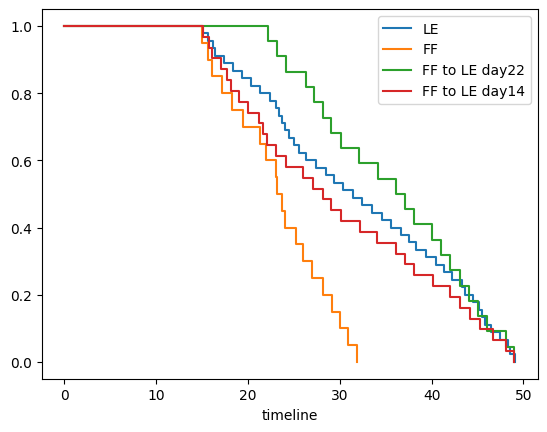

In [ ]:
km = KaplanMeierFitter(alpha=0.05)
for i in ["LE","FF","FF to LE day22","FF to LE day14"]:
  km.fit(all.loc[all['label']==i]['time'], all.loc[all['label']==i]['event'],label=i)
  km.plot(ci_show=False)

In [ ]:
from lifelines import NelsonAalenFitter

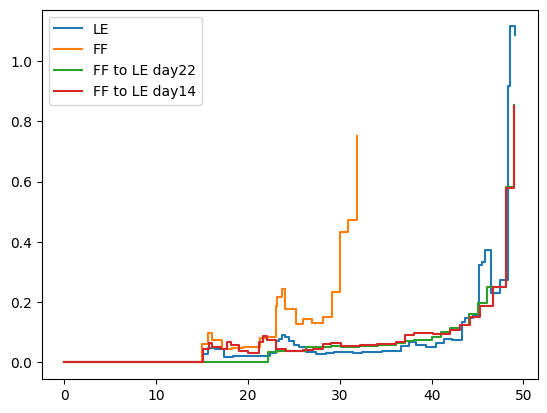

In [ ]:
naf = NelsonAalenFitter()
for i in ["LE","FF","FF to LE day22","FF to LE day14"]:
  naf.fit(all.loc[all['label']==i]['time'], all.loc[all['label']==i]['event'],label=i)
  naf.plot_hazard(ci_show=False,bandwidth=1)